In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('CFBeattendance.csv', encoding='ISO-8859-1')

In [2]:
# Sort by team and year to ensure cumulative calculations are in the correct order
df = df.sort_values(by=['Team', 'Year']).reset_index(drop=True)

# Group by 'Team' and calculate cumulative wins and losses
df['Cumulative_Wins'] = df.groupby('Team')['Current Wins'].cumsum()
df['Cumulative_Losses'] = df.groupby('Team')['Current Losses'].cumsum()
df['Cumulative_Games_Played'] = df['Cumulative_Wins'] + df['Cumulative_Losses']

# Calculate cumulative win percentage, handling cases with zero games played
df['Cumulative_Win_Percentage'] = (df['Cumulative_Wins'] / df['Cumulative_Games_Played']).fillna(0) * 100

In [3]:
# Filtering out rows where the Year column is 2000
df = df[df['Year'] != 2000]

# Filtering Out Years For Teams First Year in FBS
first_years_to_remove = {
    'Ball State': 2006,
    'FIU': 2002,
    'Georgia State': 2011,
    'Kent State': 2002,
    'Louisiana': 2004,
    'Middle Tennessee': 2001,
    'Nevada': 2002,
    'South Alabama': 2009,
    'Troy': 2007,
    'Western Kentucky': 2008
}

for team, year in first_years_to_remove.items():
    df = df[~((df['Team'] == team) & (df['Year'] == year))]

In [4]:
X = df[['Cumulative_Win_Percentage']]
y = df['Fill Rate']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model selection
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')

Mean Absolute Error: 0.1491934327875352
Mean Squared Error: 0.035312595591168325


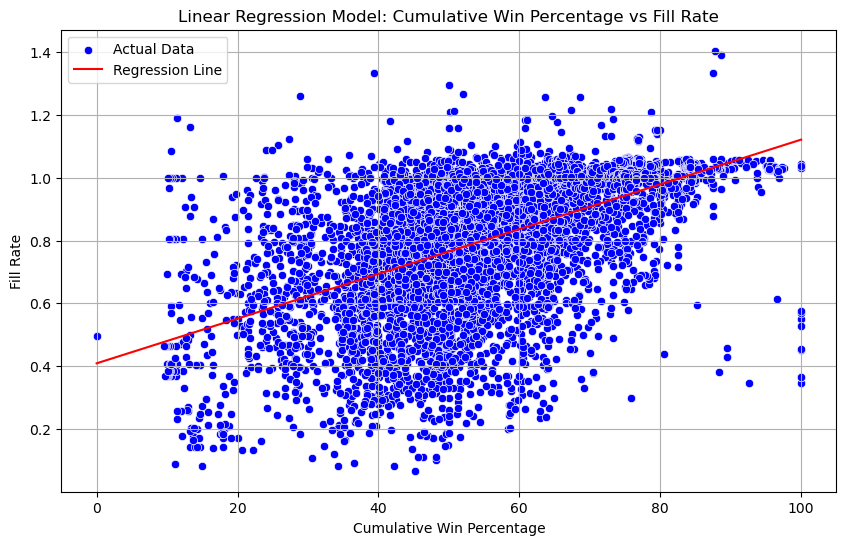

In [5]:
# Generate predictions for the whole dataset to plot the regression line
df['Predicted_Fill_Rate'] = model.predict(X)

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Cumulative_Win_Percentage', y='Fill Rate', label='Actual Data', color='blue')
sns.lineplot(data=df, x='Cumulative_Win_Percentage', y='Predicted_Fill_Rate', label='Regression Line', color='red')
plt.title('Linear Regression Model: Cumulative Win Percentage vs Fill Rate')
plt.xlabel('Cumulative Win Percentage')
plt.ylabel('Fill Rate')
plt.legend()
plt.grid()
plt.show()

In [6]:
X = df[['Fill Rate']]
y = df['Cumulative_Win_Percentage']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model selection
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')

Mean Absolute Error: 10.389773672681084
Mean Squared Error: 175.17612030432818


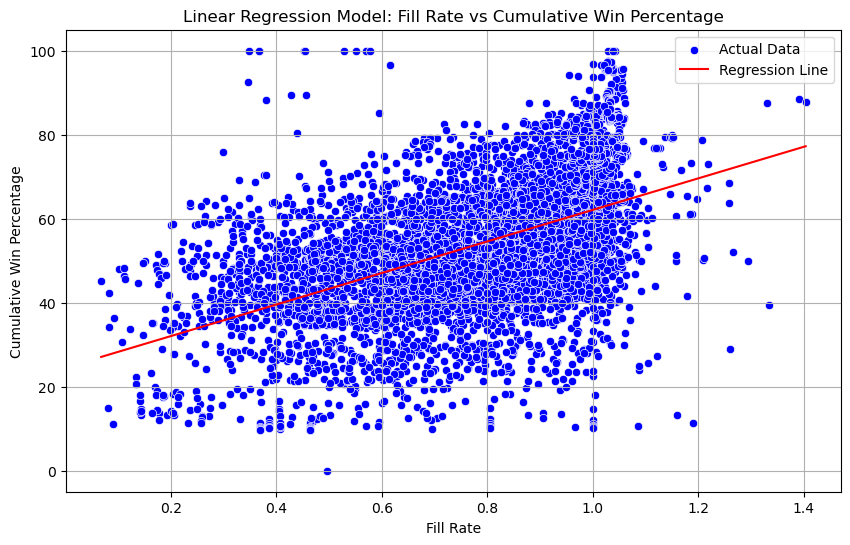

In [7]:
# Generate predictions for the whole dataset to plot the regression line
df['Predicted_Cumulative_Win_Percentage'] = model.predict(X)

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Fill Rate', y='Cumulative_Win_Percentage', label='Actual Data', color='blue')
sns.lineplot(data=df, x='Fill Rate', y='Predicted_Cumulative_Win_Percentage', label='Regression Line', color='red')
plt.title('Linear Regression Model: Fill Rate vs Cumulative Win Percentage')
plt.xlabel('Fill Rate')
plt.ylabel('Cumulative Win Percentage')
plt.legend()
plt.grid()
plt.show()

In [8]:
def test_bidirectional_causality(data, column1, column2, max_lags=5):
    # Clean the data & give easier naming conventions
    data_clean = pd.DataFrame({
        'x': data[column1],
        'y': data[column2]
    }).dropna()
    
    # Test first direction (Win Percentage -> Fill Rate)
    results_forward = grangercausalitytests(data_clean[['y', 'x']], maxlag=max_lags, verbose=False)
    
    # Test reverse direction (Fill Rate -> Win Percentage)
    results_reverse = grangercausalitytests(data_clean[['x', 'y']], maxlag=max_lags, verbose=False)
    
    return results_forward, results_reverse

def format_results(results):
    formatted = {}
    for lag in results:
        stats = results[lag][0]
        formatted[lag] = {
            'f_stat': stats['ssr_ftest'][0],
            'p_value': stats['ssr_ftest'][1]
        }
    return formatted

def interpret_bidirectional_results(results_forward, results_reverse, column1, column2, significance_level=0.05):
    forward = format_results(results_forward)
    reverse = format_results(results_reverse)
    
    print(f"\nResults for {column1} -> {column2}:")
    for lag, values in forward.items():
        print(f"Lag {lag}: {'Evidence' if values['p_value'] < significance_level else 'No evidence'} "
              f"of Granger causality (F-stat: {values['f_stat']:.4f}, p-value: {values['p_value']:.4f})")
    
    print(f"\nResults for {column2} -> {column1}:")
    for lag, values in reverse.items():
        print(f"Lag {lag}: {'Evidence' if values['p_value'] < significance_level else 'No evidence'} "
              f"of Granger causality (F-stat: {values['f_stat']:.4f}, p-value: {values['p_value']:.4f})")
    
    # Summarizing the relationship
    forward_significant = any(values['p_value'] < significance_level for values in forward.values())
    reverse_significant = any(values['p_value'] < significance_level for values in reverse.values())
    
    print("\nSummary:")
    if forward_significant and reverse_significant:
        print(f"There is bi-directional Granger causality between {column1} and {column2}")
    elif forward_significant:
        print(f"{column1} Granger-causes {column2}, but not vice versa")
    elif reverse_significant:
        print(f"{column2} Granger-causes {column1}, but not vice versa")
    else:
        print(f"No Granger causality found in either direction between {column1} and {column2}")

In [9]:
results_forward, results_reverse = test_bidirectional_causality(df, 'Cumulative_Win_Percentage', 'Fill Rate')
interpret_bidirectional_results(results_forward, results_reverse, 'Cumulative_Win_Percentage', 'Fill Rate')


Results for Cumulative_Win_Percentage -> Fill Rate:
Lag 1: Evidence of Granger causality (F-stat: 272.0656, p-value: 0.0000)
Lag 2: Evidence of Granger causality (F-stat: 83.0474, p-value: 0.0000)
Lag 3: Evidence of Granger causality (F-stat: 50.4803, p-value: 0.0000)
Lag 4: Evidence of Granger causality (F-stat: 37.8659, p-value: 0.0000)
Lag 5: Evidence of Granger causality (F-stat: 34.4404, p-value: 0.0000)

Results for Fill Rate -> Cumulative_Win_Percentage:
Lag 1: Evidence of Granger causality (F-stat: 15.3103, p-value: 0.0001)
Lag 2: Evidence of Granger causality (F-stat: 7.2514, p-value: 0.0007)
Lag 3: Evidence of Granger causality (F-stat: 5.4314, p-value: 0.0010)
Lag 4: Evidence of Granger causality (F-stat: 4.3636, p-value: 0.0016)
Lag 5: Evidence of Granger causality (F-stat: 3.5666, p-value: 0.0032)

Summary:
There is bi-directional Granger causality between Cumulative_Win_Percentage and Fill Rate


In [12]:
def create_causality_visualizations(f_stats_forward, f_stats_reverse, p_values_forward, p_values_reverse, lags):
    # Create data for plotting
    data = pd.DataFrame({
        'lag': lags,
        'win_to_fill_f': f_stats_forward,
        'fill_to_win_f': f_stats_reverse,
        'win_to_fill_p': p_values_forward,
        'fill_to_win_p': p_values_reverse
    })
    
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 12))
    
    # 1. F-Statistics Line Plot
    ax1 = plt.subplot(2, 2, 1)
    plt.plot(data['lag'], data['win_to_fill_f'], 'b-o', label='Win % → Fill Rate')
    plt.plot(data['lag'], data['fill_to_win_f'], 'g-o', label='Fill Rate → Win %')
    plt.title('F-Statistics by Lag Period')
    plt.xlabel('Lag Period')
    plt.ylabel('F-Statistic')
    plt.legend()
    plt.grid(True)
    
    # 2. P-Values Bar Plot
    ax2 = plt.subplot(2, 2, 2)
    bar_width = 0.35
    index = np.arange(len(lags))
    plt.bar(index - bar_width/2, data['win_to_fill_p'], bar_width, 
            label='Win % → Fill Rate', alpha=0.8, color='b')
    plt.bar(index + bar_width/2, data['fill_to_win_p'], bar_width,
            label='Fill Rate → Win %', alpha=0.8, color='g')
    plt.title('P-Values by Lag Period')
    plt.xlabel('Lag Period')
    plt.ylabel('P-Value')
    plt.xticks(index, lags)
    plt.legend()
    plt.grid(True)
    
    # 3. Relationship Strength Scatter Plot
    ax3 = plt.subplot(2, 2, 3)
    plt.scatter(data['win_to_fill_f'], data['fill_to_win_f'], c=data['lag'], 
                cmap='viridis', s=100)
    for i, lag in enumerate(lags):
        plt.annotate(f'Lag {lag}', 
                    (data['win_to_fill_f'][i], data['fill_to_win_f'][i]),
                    xytext=(5, 5), textcoords='offset points')
    plt.title('Relationship Strength Comparison')
    plt.xlabel('F-Statistic (Win % → Fill Rate)')
    plt.ylabel('F-Statistic (Fill Rate → Win %)')
    plt.grid(True)

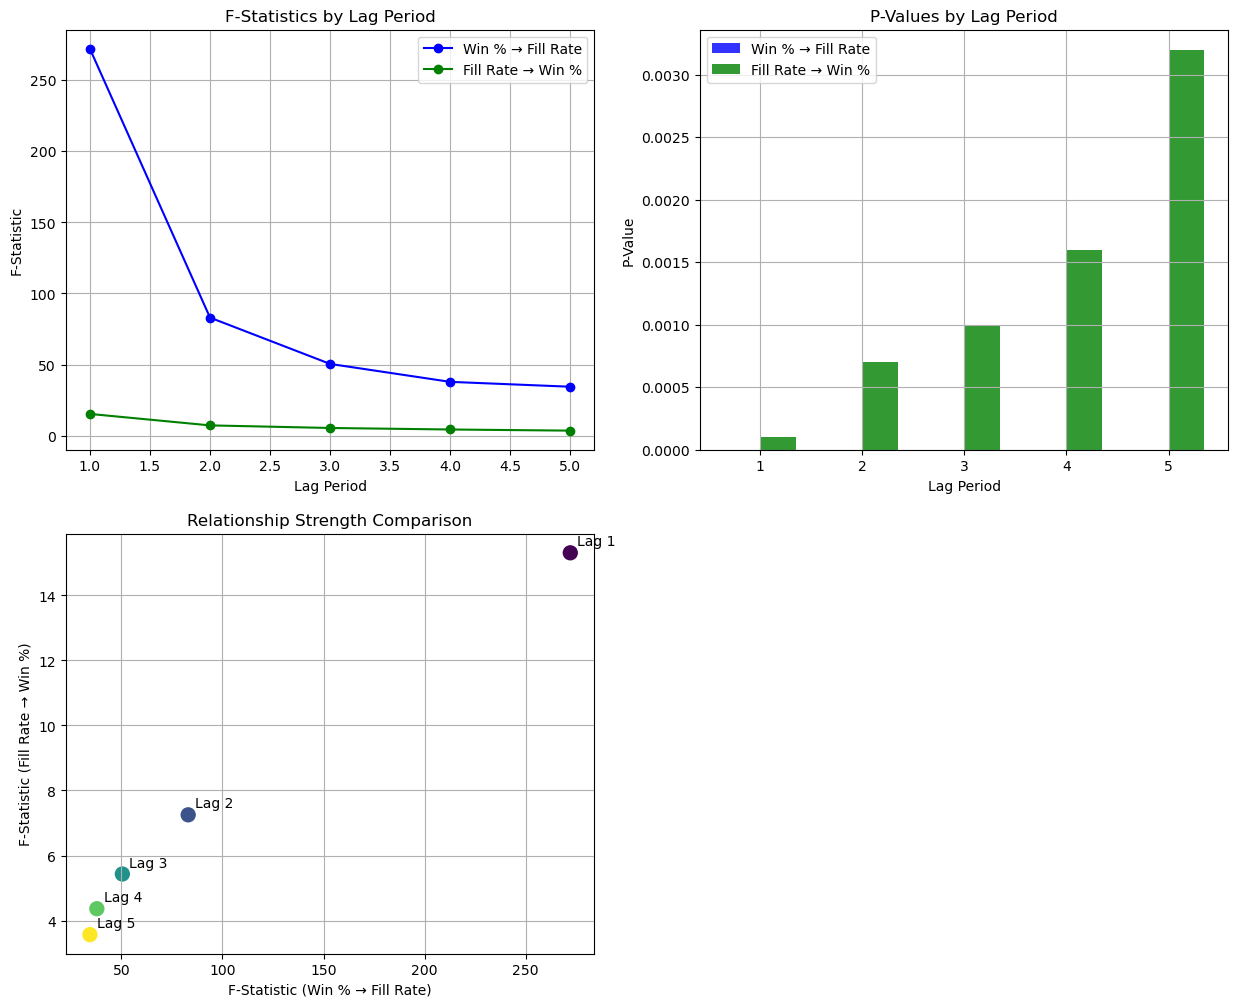

In [13]:
f_stats_forward = [272.0656, 83.0474, 50.4803, 37.8659, 34.4404]
f_stats_reverse = [15.3103, 7.2514, 5.4314, 4.3636, 3.5666]
p_values_forward = [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]
p_values_reverse = [0.0001, 0.0007, 0.0010, 0.0016, 0.0032]
lags = [1, 2, 3, 4, 5]

create_causality_visualizations(
    f_stats_forward,
    f_stats_reverse,
    p_values_forward,
    p_values_reverse,
    lags
)